In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.pyplot import savefig
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline

import seaborn as sns
sns.set_style("ticks")
sns.set_context(context='paper',font_scale=1.2)
sns.despine()

import yaml
import os
from sklearn.model_selection import ParameterGrid
import warnings
warnings.filterwarnings('ignore')

<Figure size 432x288 with 0 Axes>

In [4]:
tasks = ['hospital_mortality', 'LOS_7', 'icu_admission', 'readmission_30', 'bladder_cancer', 'breast_cancer',  'renal_cancer', 'diabetic_ketoacidosis', 'edema', 'hyperkylemia', 'revascularization','stroke', 'sudden_cardiac_death', 'acute_renal_failure', 'acute_myocardial_infarction']
metrics = ['auc', 'auprc', 'ace_abs_logistic_log']
model_path = '/local-scratch/nigam/projects/jlemmon/cl-clmbr/experiments/main/artifacts/models'
results_path = '/local-scratch/nigam/projects/jlemmon/cl-clmbr/experiments/main/artifacts/results'
figure_path = '/local-scratch/nigam/projects/jlemmon/cl-clmbr/experiments/main/notebooks/figures'

num_cl = 2
titles = {'hospital_mortality':'In-hospital\nMortality', 'LOS_7':'Length of Stay\n> 7 days', 'icu_admission':'Admission to\nICU', 'readmission_30':'Readmission after\n30 days', 'stroke':'Stroke','bladder_cancer':'Bladder Cancer','breast_cancer':'Breast Cancer', 'renal_cancer':'Renal Cancer', 'diabetic_ketoacidosis':'Diabetic\nKetoacidosis', 'edema':'Edema', 'sudden_cardiac_death':'Sudden Cardiac\nDeath', 'acute_renal_failure':'Acute Renal\nFailure', 'acute_myocardial_infarction':'Acute Myocardial\nInfarction', 'edema':'Edema', 'hyperkylemia':'Hyperkylemia', 'revascularization':'Revascularization'}

In [52]:
y_axis = {
    'auc':{
        'lim':[-0.03, 0.025],
        'label':'AUROC'
    },
    'auprc':{
        'lim':[-0.12, 0.12],
        'label':'AUPRC'
    },
    'ace_abs_logistic_log':{
        'lim':[-0.0128, 0.0111],
        'label':'Calibration'
    }
}

bg_colours = {
    'hospital_mortality':'lightgray', 
    'LOS_7':'red', 
    'icu_admission':'sienna', 
    'readmission_30':'orange', 
    'sudden_cardiac_death':'gold', 
    'stroke':'darkkhaki',
    'bladder_cancer':'chartreuse',
    'breast_cancer':'deepskyblue', 
    'acute_renal_failure':'deeppink', 
    'acute_myocardial_infarction':'purple', 
    'diabetic_ketoacidosis':'green', 
    'edema':'crimson', 
    'hyperkylemia':'midnightblue', 
    'renal_cancer':'fuchsia', 
    'revascularization':'turquoise'
}

In [53]:
# Get baseline model
bl_df = pd.DataFrame()
for task in tasks:
    df = pd.read_csv(f'{results_path}/{task}/probes/baseline/gru_sz_800_do_0.1_cd_0_dd_0_lr_0.001_l2_0.01/eval.csv')
    df['task'] = task
    df['model'] = 'BL'
    bl_df = pd.concat([bl_df,df])

In [54]:
mr_grid = list(
    ParameterGrid(
        yaml.load(
            open(
                f"{os.path.join('/local-scratch/nigam/projects/jlemmon/cl-clmbr/experiments/main/artifacts/models/clmbr/contrastive_learn/models/gru_sz_800_do_0.1_cd_0_dd_0_lr_0.001_l2_0.01/best','hyperparams')}.yml",
                'r'
            ),
            Loader=yaml.FullLoader
        )
    )
)[0]

rd_grid = list(
    ParameterGrid(
        yaml.load(
            open(
                f"{os.path.join('/local-scratch/nigam/projects/jlemmon/cl-clmbr/experiments/main/artifacts/models/clmbr/contrastive_learn/models/gru_sz_800_do_0.1_cd_0_dd_0_lr_0.001_l2_0.01/best_rand_day','hyperparams')}.yml",
                'r'
            ),
            Loader=yaml.FullLoader
        )
    )
)[0]

In [55]:
# Get best CL model by validation score for each task

rd_df = pd.DataFrame()
for task in tasks:
    df = pd.read_csv(f'{results_path}/{task}/probes/contrastive_learn/gru_sz_800_do_0.1_cd_0_dd_0_lr_0.001_l2_0.01/bs_3000_lr_3e-5_temp_0.01_pool_rand_day/eval.csv')
    df['task'] = task
    df['model'] = f'CL-RD'
    rd_df = pd.concat([rd_df,df])

In [56]:
mr_df = pd.DataFrame()
for task in tasks:
    df = pd.read_csv(f'{results_path}/{task}/probes/contrastive_learn/gru_sz_800_do_0.1_cd_0_dd_0_lr_0.001_l2_0.01/bs_3000_lr_3e-5_temp_0.01_pool_mean_rep/eval.csv')
    df['task'] = task
    df['model'] = f'CL-MR'
    mr_df = pd.concat([mr_df,df])

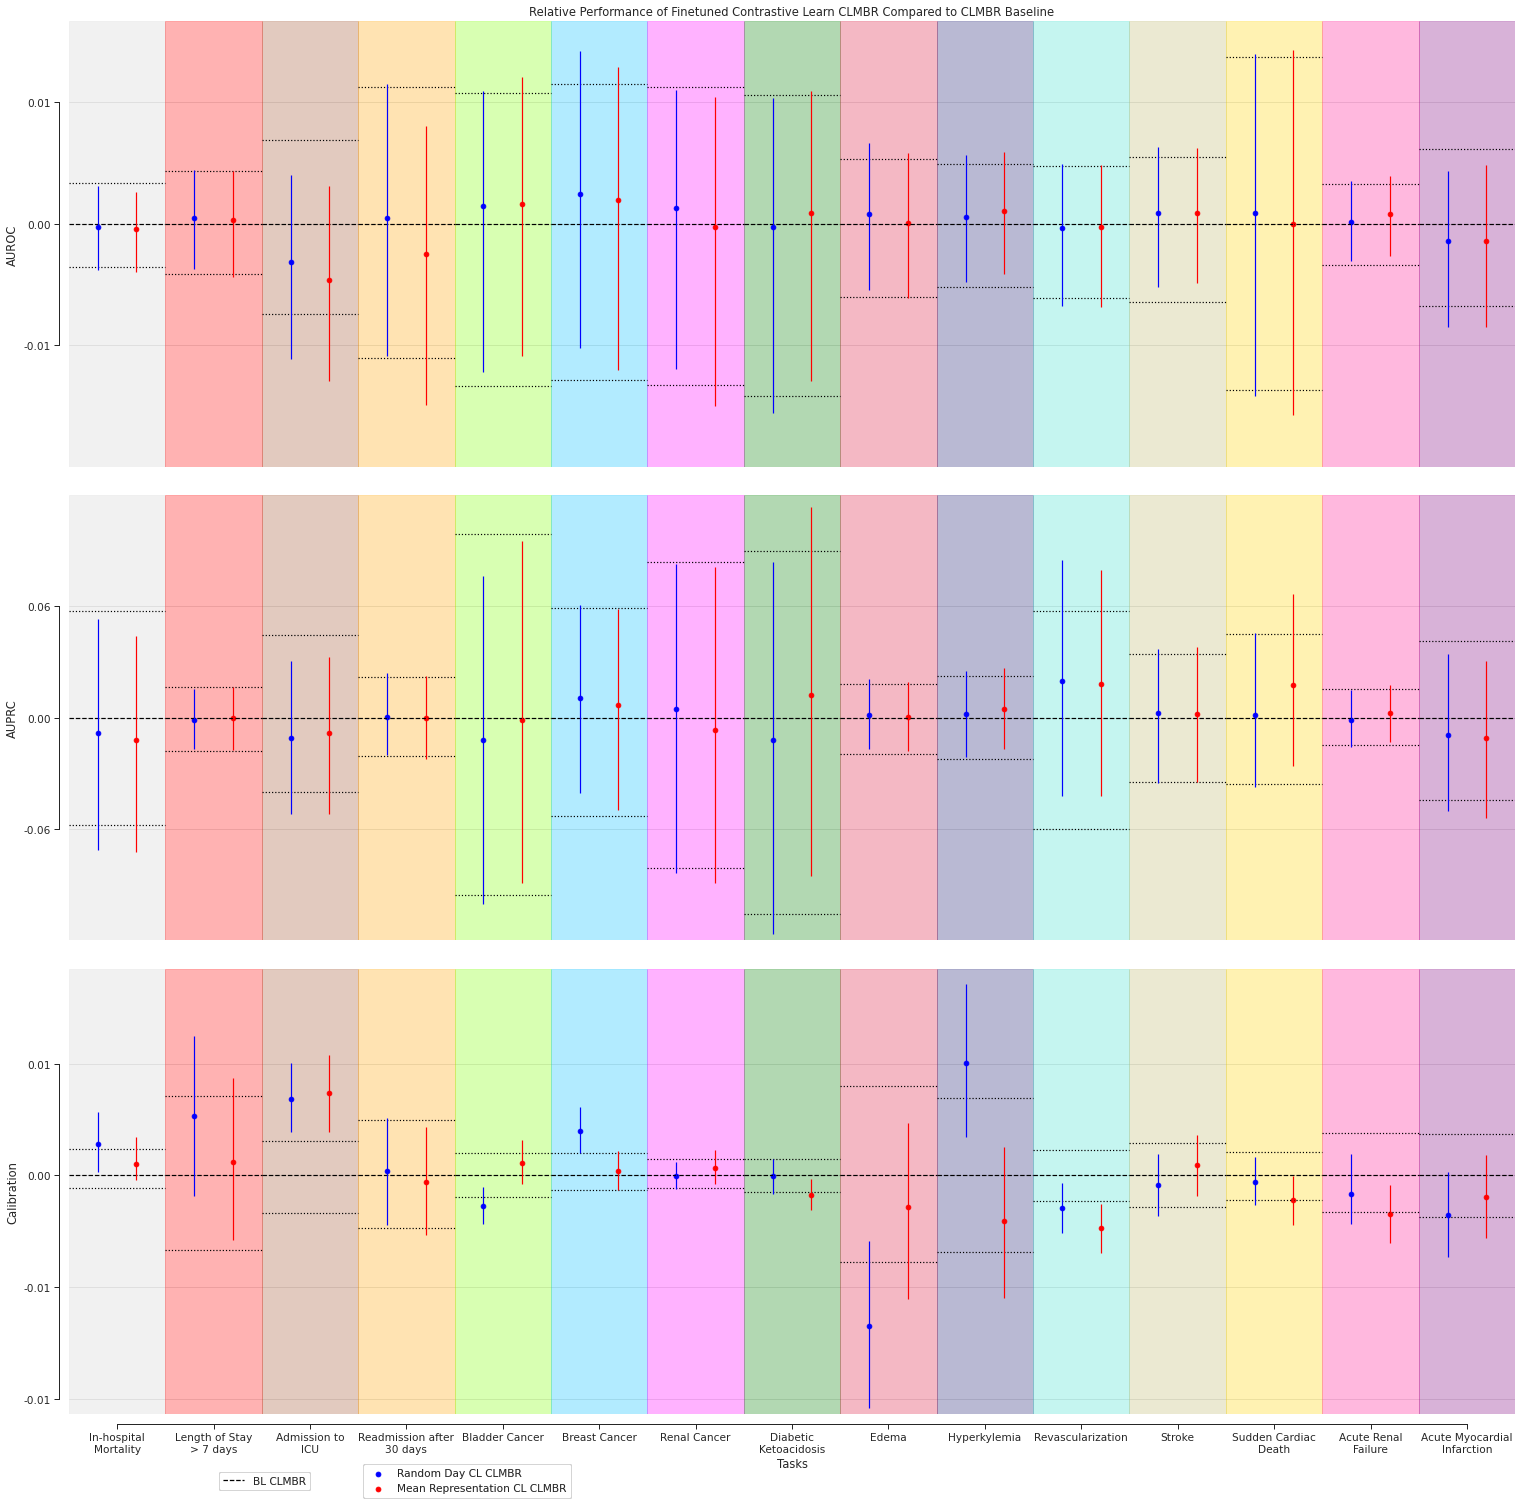

In [57]:
# For each task plot baseline vs CL
fig, axes = plt.subplots(nrows=len(metrics), ncols=1, figsize=(22,25))
plt.tight_layout(w_pad=1,h_pad=0.5,rect=[0.05,0.15,1,0.95])

for r, metric in enumerate(metrics):
    for c, task in enumerate(tasks):
        bl_leg = []
        cl_leg = []
        axes[r].axvspan(c+0.5, c+1.5,0,1,color=bg_colours[task], alpha=0.3)
        bl_evals = bl_df.query('task==@task and metric==@metric and phase=="test"')
        rd_evals = rd_df.query('task==@task and metric==@metric and phase=="test"')
        mr_evals = mr_df.query('task==@task and metric==@metric and phase=="test"')
        
        bl_evals['CI_upper'] = (bl_evals['CI_upper'] - bl_evals['CI_med']).abs()
        bl_evals['CI_lower'] = (bl_evals['CI_med'] - bl_evals['CI_lower']).abs()
        
        rd_evals['CI_upper'] = (rd_evals['CI_upper'] - rd_evals['CI_med']).abs()
        rd_evals['CI_lower'] = (rd_evals['CI_med'] - rd_evals['CI_lower']).abs()
        
        mr_evals['CI_upper'] = (mr_evals['CI_upper'] - mr_evals['CI_med']).abs()
        mr_evals['CI_lower'] = (mr_evals['CI_med'] - mr_evals['CI_lower']).abs()
        
        rd_evals['CI_med'] = rd_evals['CI_med'] - bl_evals['CI_med']
        mr_evals['CI_med'] = mr_evals['CI_med'] - bl_evals['CI_med']
        bl_evals['CI_med'] = bl_evals['CI_med'] - bl_evals['CI_med']
    
        
        bl_line = axes[r].plot([c+0.5, c+1.5],[bl_evals['CI_med'], bl_evals['CI_med']], linestyle='dashed', color='black')
        axes[r].plot([c+0.5, c+1.5],[bl_evals['CI_upper'], bl_evals['CI_upper']], linestyle='dotted', color='black')
        axes[r].plot([c+0.5, c+1.5],[-bl_evals['CI_lower'], -bl_evals['CI_lower']], linestyle='dotted', color='black')
    
        bl_leg.append(bl_line)
        rd_line = axes[r].scatter(
            c+0.8,
            rd_evals['CI_med'],
            color = 'blue'
        )
        cl_leg.append(rd_line)
        axes[r].errorbar(
            c+0.8,
            rd_evals['CI_med'],
            rd_evals[['CI_lower', 'CI_upper']].values.T,
            color = 'blue'
        )
        
        mr_line = axes[r].scatter(
            c+1.2,
            mr_evals['CI_med'],
            color = 'red'
        )
        cl_leg.append(mr_line)
        axes[r].errorbar(
            c+1.2,
            mr_evals['CI_med'],
            mr_evals[['CI_lower', 'CI_upper']].values.T,
            color = 'red'
        )
        
        plt.xticks(np.arange(1,len(tasks)+1,1))
        axes[r].set_ylim(y_axis[metric]['lim'])
        axes[r].set_xlim([0.5,len(tasks)+0.5])
        axes[r].yaxis.set_major_locator(MaxNLocator(nbins=4,prune='both'))
        axes[r].grid(which='major', linewidth=0.5, axis='y')
        if r == 0:
            axes[r].set_title('Relative Performance of Finetuned Contrastive Learn CLMBR Compared to CLMBR Baseline')
        if r == len(metrics) - 1:
            axes[r].set_xlabel('Tasks')
            axes[r].set_xticklabels(labels=[titles[t] for t in tasks])
            bl_leg = [x[0]for x in bl_leg]
            bl_leg_lbls = ['BL CLMBR']
            bl_legend = plt.legend(bl_leg, bl_leg_lbls, bbox_to_anchor=(0.1,-0.2,0.1,0.1), loc="center left")
            plt.gca().add_artist(bl_legend)
            cl_leg_lbls = ['Random Day CL CLMBR', 'Mean Representation CL CLMBR']
            cl_legend = plt.legend(cl_leg, cl_leg_lbls, bbox_to_anchor=(0.2,-0.2,0.1,0.1), loc="center left")
            plt.gca().add_artist(cl_legend)
            
        else:
            axes[r].set_xticklabels('')
            axes[r].set_xlabel('')
            axes[r].spines['bottom'].set_color('white')
            axes[r].tick_params(axis='x', length=0)  
        axes[r].set_ylabel(y_axis[metric]['label'])
        axes[r].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        
sns.despine(offset=10, trim=True,)


plt.savefig('figures/base_task_eval.png', bbox_inches='tight')
plt.show()


In [39]:
for t in tasks:
    s = f""
    s += "\\multirow{3}{*}{" + f"{t}".replace('_', ' ').capitalize() + "}"
    s += " &"
    s += "  AUROC" 
    s +=" & "
    s += '{0:.4f}'.format(bl_df.query("task==@t and phase=='test' and metric=='auc'")['CI_med'].values[0])
    s += "(" + '{0:.4f}'.format(bl_df.query("task==@t and phase=='test' and metric=='auc'")['CI_lower'].values[0]) + "," + '{0:.4f}'.format(bl_df.query("task==@t and phase=='test' and metric=='auc'")['CI_upper'].values[0]) + ")"
    s += " & "
    s += '{0:.4f}'.format(cl_df.query("task==@t and phase=='test' and metric=='auc'")['CI_med'].values[0])
    s += "(" + '{0:.4f}'.format(cl_df.query("task==@t and phase=='test' and metric=='auc'")['CI_lower'].values[0]) + "," + '{0:.4f}'.format(cl_df.query("task==@t and phase=='test' and metric=='auc'")['CI_upper'].values[0]) + ")"
    s += "\\\\"
    s += " &"
    s += "  AUPRC" 
    s +=" & "
    s += '{0:.4f}'.format(bl_df.query("task==@t and phase=='test' and metric=='auprc'")['CI_med'].values[0])
    s += "(" + '{0:.4f}'.format(bl_df.query("task==@t and phase=='test' and metric=='auprc'")['CI_lower'].values[0]) + "," + '{0:.4f}'.format(bl_df.query("task==@t and phase=='test' and metric=='auc'")['CI_upper'].values[0]) + ")"
    s += " & "
    s += '{0:.4f}'.format(cl_df.query("task==@t and phase=='test' and metric=='auprc'")['CI_med'].values[0])
    s += "(" + '{0:.4f}'.format(cl_df.query("task==@t and phase=='test' and metric=='auprc'")['CI_lower'].values[0]) + "," + '{0:.4f}'.format(cl_df.query("task==@t and phase=='test' and metric=='auc'")['CI_upper'].values[0]) + ")"
    s += "\\\\"
    s += " &"
    s += "  ACE" 
    s +=" & "
    s += '{0:.4f}'.format(bl_df.query("task==@t and phase=='test' and metric=='ace_abs_logistic_log'")['CI_med'].values[0])
    s += "(" + '{0:.4f}'.format(bl_df.query("task==@t and phase=='test' and metric=='ace_abs_logistic_log'")['CI_lower'].values[0]) + "," + '{0:.4f}'.format(bl_df.query("task==@t and phase=='test' and metric=='ace_abs_logistic_log'")['CI_upper'].values[0]) + ")"
    s += " & "
    s += '{0:.4f}'.format(cl_df.query("task==@t and phase=='test' and metric=='ace_abs_logistic_log'")['CI_med'].values[0])
    s += "(" + '{0:.4f}'.format(cl_df.query("task==@t and phase=='test' and metric=='ace_abs_logistic_log'")['CI_lower'].values[0]) + "," + '{0:.4f}'.format(cl_df.query("task==@t and phase=='test' and metric=='ace_abs_logistic_log'")['CI_upper'].values[0]) + ")"
    s += "\\\\ \\hline"
    print(s)

IndexError: index 0 is out of bounds for axis 0 with size 0